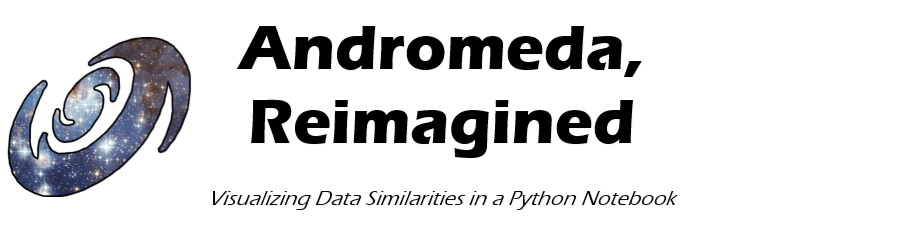

Author: **Vincent Zhao** <br>
Date Created: **09-MAY-2018** <br>
Version: **8.12** <br>

***

<a id='toc'></a>
# Table of Contents
1. [**Introduction: Purpose and Guidelines**](#project_desc)
3. **Data Processing**
    1. [Distance Calculation](#distance_calc)
    2. [Dimension Reduction](#dim_reduction)
4. **Data Visualization**
    1. [Static Display](#static_viz)
    2. [Dynamic Display](#dynamic_viz)
5. [**Version Notes**](#version_notes)


<a id='project_desc'></a>
# Introduction: Purpose and Guidelines
The purpose of this research project is to recreate the data visualization tool, *Andromeda*, in a python notebook. The functionality will be implemented as follows:

   * Read in the data from a file.
   * Compute an L1 Distance Matrix and display it in an MDS plot. Make sure to label the points!
   * Make sliders (one slider per column of data)
   * Use the slider values to ccontrol a set of weights, and compute the weighted distance matrix. Initially set the slider range to be from 0.0 to 2.0.
   * Be able to re-display the MDS plot after changing the sliders.
   * Be able to click on a dot and be able to see the details.

**MDS** or **Multi-Dimensional Scaling** is the visualization of "similarities" between items in a dataset, based on its quantitative attributes. It transforms information from a high dimensional **distance matrix** into N-dimensional coordinate points that can be plotted on an MDS plot.

Andromeda is a tool that uses MDS plots to help users understand the natural clusters of their dataset, and allows users to interact with different widgets that correspond to traits that they want to see emphasized in the display.
   
** EXTRA CHALLENGE: **
   * Be able to drag a point, then run an algorithm that computes the new weights given the dragged points. Then the sliders would have to adjust and the MDS plot would need to be updated [use an 'Update Layout' button].
   
   Note that there will be code provided for the algorithm in java that will need to be transcribed.

Virginia Tech Honor Code: **"I have neither given, nor received, unauthorized assistance on this assignment."** - VZ, 12-AUG-18

***

In [1]:
## IMPORT LIBRARIES
import pandas as pd
import numpy as np

# PROCESSING LIBRARIES
from scipy import special
from scipy.sparse import csr_matrix

# VISUALIZATION LIBRARIES
import plotly as py
import plotly.graph_objs as go
import ipywidgets as w

import bokeh.plotting as bkp


py.offline.init_notebook_mode(connected=True)

To help illustrate some of the fundamental techniques used to create this notebook, we will use a subset of the 'counties.csv' data which was provided in Dr. North's class.

The 'counties.csv' file contains 2 categorical data fields (listing the **Name** and **State** of each county in the US) and 6 quantitative fields detailing the **Population**, **Percent of College Grads**, **Income Per Capita**, **Total Number of Employees**, **Total Retail Sales**, and **Median Rent** for each county.

It is important to understand your dataset before attempting to apply any sort of visualization on it.

In [2]:
## Extract Subset of Data for Demo
counties_csv = pd.read_csv('data/counties.csv')

# slice out the counties of Alaska for demonstration
ak = counties_csv[counties_csv.State == 'AK'].copy().reset_index(drop = True)
ak

,Name,State,Population,PercentCollegeGrad,IncomePerCapita,Employees,RetailSales,MedianRent
0,Aleutians East,AK,2305,12.9,20114,1410,6693,518
1,Aleutians West,AK,5259,14.8,20298,4321,24233,428
2,Anchorage,AK,251335,26.9,26619,93037,2612640,528
3,Bethel,AK,15525,13.1,15493,2269,59687,460
4,Bristol Bay,AK,1023,18.9,29699,392,9653,464
5,Dillingham,AK,4360,15.3,22616,1060,23077,518
6,Fairbanks North Star,AK,83374,25.2,19149,17746,702135,471
7,Haines,AK,2181,17.6,26413,371,15154,405
8,Juneau,AK,29378,30.7,26066,8369,289620,587
9,Kenai Peninsula,AK,46151,17.9,22761,8934,329438,410


<a id='distance_calc'></a>
# Distance Calculation

Essentially, we want to determine the overall "different-ness" of each data entry based on its quantitative attributes. To do this, we first isolate the quantitative columns of data and normalize them (in this notebook we use z-score normalization).

Once the data has been normalized, a distance matrix can be calculated with consideration for the "weight" of each column. This distance matrix is calculated based on __[Manhattan (L1) Distance](https://en.wikipedia.org/wiki/Taxicab_geometry)__. 

[Return to Table of Contents](#toc)

In [4]:
## z-score the highDdata (quant data)
quant_data = [ak.iloc[:, i] for i in range(len(ak.columns))
              if (ak.iloc[:, i].dtype == np.int64 or ak.iloc[:, i].dtype == np.float64)]

quant = pd.DataFrame(quant_data).T

n_rows = len(quant)
n_cols = len(quant.columns)

# FUNCTION: zscores a given HDdata column by column
def zscore(highDdata):
    for col in range(n_cols):
        
        # assign mean and std to variables for efficiency
        col_mean = highDdata.iloc[:, col].mean()
        col_std = highDdata.iloc[:, col].std()
        
        # calculate zscore for each item in the col
        for item in range(n_rows):
            curr = highDdata.iloc[item, col]
            highDdata.iloc[item, col] = (curr - col_mean)/col_std
            
    return highDdata
    
zscore_HD = zscore(quant)
zscore_HD

,Population,PercentCollegeGrad,IncomePerCapita,Employees,RetailSales,MedianRent
0,-0.426408,-0.919620,-0.231429,-0.291118,-0.375244,0.574073
1,-0.368534,-0.538784,-0.193121,-0.132832,-0.341867,-0.386272
2,4.452550,1.886545,1.122877,4.691111,4.583642,0.680778
3,-0.167404,-0.879532,-1.193496,-0.244410,-0.274401,-0.044816
4,-0.451525,0.283022,1.764116,-0.346472,-0.369611,-0.002134
5,-0.386147,-0.438564,0.289474,-0.310149,-0.344066,0.574073
6,1.161884,1.545796,-0.432337,0.597154,0.948121,0.072559
7,-0.428837,0.022449,1.079989,-0.347614,-0.359143,-0.631694
8,0.104002,2.648218,1.007745,0.087279,0.163141,1.310337
9,0.432616,0.082581,0.319662,0.118001,0.238911,-0.578341


<font color = 'red'>**NOTE:** <font color = 'black'>In the interactive portion there is a need to adjust the weights. we'll get to that later. for now we assume equal weight for each column.

In [5]:
## Create an array for the weights
default_weights = []
default_value = (1.0/n_cols)

# populate our default_weight array
for col in range(n_cols):
    default_weights.append(default_value)
    
weights = default_weights
weights

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666]

***
As we learned in class, you can leverage the `sklearn` library to create an L1 distance matrix by calling `sklearn.metrics.pairwise.manhattan_distances`.

HOWEVER, this function does not factor in a "weight" for each column of data. After many hours of research, I was able to combine information about the `sklearn` method and the method located in the original java version of Andromeda to construct a **custom distance matrix function** that accounts for weights.

***

In [6]:
## Create distance matrix

# calculates the weighted L1 distance between two rows of HD data
def weighted_man_dist(row_currHD, row_compareHD, weight_vector):
    dist = 0.0
    for col in range(n_cols):
        dist += abs(row_currHD[col] - row_compareHD[col]) * weight_vector[col]
    return dist

# creates a weighted L1 distance matrix
def create_dist_matrix(zscore_HDdata, weight_vector):
    n_rows = len(zscore_HDdata)
    cm = csr_matrix(zscore_HDdata)
    output = np.zeros((cm.shape[0], cm.shape[0])) # create a sparse matrix the shape of our output
    
    for i in range(n_rows):
        j = i + 1
        for j in range(n_rows):
            output[i][j] = weighted_man_dist(zscore_HDdata.iloc[i, :], \
                                             zscore_HDdata.iloc[j, :], \
                                             weight_vector)
            output[j][i] = output[i][j]
    output = pd.DataFrame(output)
    return output

distHD = create_dist_matrix(zscore_HD, weights)
distHD

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.271504,3.181208,0.337933,0.643416,0.182072,1.161294,0.589047,1.165078,0.764667,...,0.375519,0.341959,0.522334,0.444972,0.625896,0.532934,0.562938,0.725761,0.585120,0.650799
1,0.271504,0.000000,3.229819,0.343792,0.581259,0.290048,1.055503,0.395354,1.213689,0.493163,...,0.520670,0.583046,0.443306,0.516764,0.411098,0.326960,0.436795,0.646734,0.361411,0.513874
2,3.181208,3.229819,0.000000,3.370260,2.970431,3.005480,2.254054,3.013725,2.479874,2.800679,...,3.061781,3.444754,3.660194,2.736236,3.319529,3.268733,2.835237,3.867267,2.937545,3.738482
3,0.337933,0.343792,3.370260,0.000000,0.774040,0.482829,1.116206,0.701954,1.354130,0.747423,...,0.632667,0.456681,0.387855,0.678530,0.716218,0.468319,0.583694,0.497006,0.638269,0.414991
4,0.643416,0.581259,2.970431,0.774040,0.000000,0.483280,1.234781,0.268093,0.992678,0.696373,...,0.633126,0.977299,0.965714,0.487429,0.605574,0.564938,0.207776,1.157940,0.331063,1.026779
5,0.182072,0.290048,3.005480,0.482829,0.483280,0.000000,1.159201,0.425421,0.989350,0.588940,...,0.279967,0.494019,0.674503,0.269244,0.443825,0.524496,0.387210,0.877676,0.409392,0.744084
6,1.161294,1.055503,2.254054,1.116206,1.234781,1.159201,0.000000,1.263780,1.022170,0.797291,...,1.381192,1.393439,1.406140,0.921637,1.398308,1.014678,1.078629,1.613212,1.053105,1.484427
7,0.589047,0.395354,3.013725,0.701954,0.268093,0.425421,1.263780,0.000000,1.021677,0.466489,...,0.575267,0.919440,0.698002,0.516427,0.337862,0.384084,0.185151,0.890228,0.210675,0.759067
8,1.165078,1.213689,2.479874,1.354130,0.992678,0.989350,1.022170,1.021677,0.000000,0.929584,...,0.835798,1.218771,1.644064,0.720106,1.303399,1.252603,0.836526,1.851137,0.921415,1.722352
9,0.764667,0.493163,2.800679,0.747423,0.696373,0.588940,0.797291,0.466489,0.929584,0.000000,...,0.800868,1.063781,0.859515,0.575161,0.601017,0.541549,0.488597,1.066588,0.425442,0.937803


<a id='dim_reduction'></a>
# Dimension Reduction

Now that we know how "far" each entry is from every other entry, we can apply **dimension reduction** to visualize the distances on a 2D display.

The `sklearn` library will be leveraged for its provided mds functionality. 

[Return to Table of Contents](#toc)

In [7]:
## create lowDdata
# DIMENSION REDUCTION/MDS
import sklearn.manifold

mds = sklearn.manifold.MDS(n_components = 2, \
                           dissimilarity = 'precomputed', \
                           n_init = 100, \
                           max_iter = 1000)
data2D = mds.fit_transform(distHD)
data2D = pd.DataFrame(data2D, columns = ['x', 'y'])
data2D

C:\Users\zhaov\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



,x,y
0,0.209137,-0.329928
1,0.267654,-0.065200
2,-2.651025,1.310776
3,0.454091,-0.245482
4,-0.253282,0.027157
5,0.057902,-0.236617
6,-0.451518,0.831398
7,0.045222,0.128264
8,-0.911555,-0.151244
9,-0.018151,0.409657


In [8]:
# append the x and y coords to original data
ak = pd.concat([ak, data2D], axis = 1)
ak

,Name,State,Population,PercentCollegeGrad,IncomePerCapita,Employees,RetailSales,MedianRent,x,y
0,Aleutians East,AK,2305,12.9,20114,1410,6693,518,0.209137,-0.329928
1,Aleutians West,AK,5259,14.8,20298,4321,24233,428,0.267654,-0.065200
2,Anchorage,AK,251335,26.9,26619,93037,2612640,528,-2.651025,1.310776
3,Bethel,AK,15525,13.1,15493,2269,59687,460,0.454091,-0.245482
4,Bristol Bay,AK,1023,18.9,29699,392,9653,464,-0.253282,0.027157
5,Dillingham,AK,4360,15.3,22616,1060,23077,518,0.057902,-0.236617
6,Fairbanks North Star,AK,83374,25.2,19149,17746,702135,471,-0.451518,0.831398
7,Haines,AK,2181,17.6,26413,371,15154,405,0.045222,0.128264
8,Juneau,AK,29378,30.7,26066,8369,289620,587,-0.911555,-0.151244
9,Kenai Peninsula,AK,46151,17.9,22761,8934,329438,410,-0.018151,0.409657


<a id='static_viz'></a>
# Static Visualization

Using `matplotlib` we can create a basic scatterplot that shows us the results of our multi-dimensional scaling. The actual values of the coordinates are arbitrary, but the relative distance between points is directly correlated with the overall "similarity" of the counties.

[Return to Table of Contents](#toc)

Text(0.5, 1.0, 'Alaska County Differences Visualized')

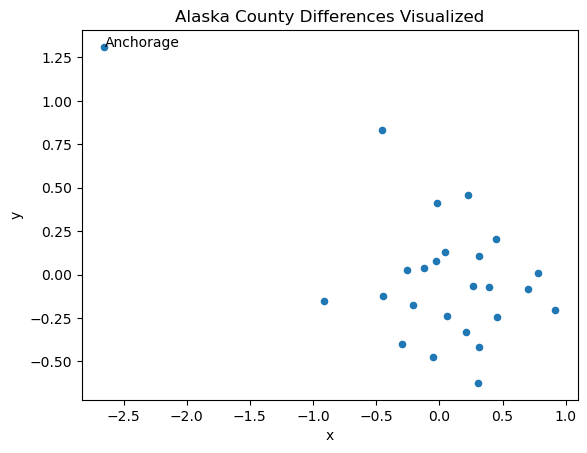

In [9]:
# static visualization
%matplotlib inline
import matplotlib

ax = data2D.plot.scatter(x = 'x', y = 'y')

# label the outlier county
ax.text(data2D.x[2], data2D.y[2], ak.Name[2])
ax.set_title('Alaska County Differences Visualized')

In [10]:
## static visualization using plotly
x = ak.x
y = ak.y

# declare the trace (assigning data)
trace = go.Scatter(x = x,
                   y = y,
                   mode = 'markers',
                   text = ak['Name']) # mouseover text goes here

# create the format for the display
layout = go.Layout(title = 'Alaska County Differences Visualized',
                   hovermode = 'closest', # adds mouseover function
                   xaxis = dict(
                       autorange = True,
                       showgrid = False,
                       zeroline = False,
                       showline = False,
                       ticks = '',
                       showticklabels = False),
                   yaxis = dict(
                       autorange = True,
                       showgrid = False,
                       zeroline = False,
                       showline = False,
                       ticks = '',
                       showticklabels = False))

# plot the data
fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig)

<a id='dynamic_viz'></a>
# Dynamic Visualization

For our dynamic visualization, we want to create widgets that will interactively update the MDS plot based on the "weight" of certain traits. For example, if we want to see which counties in Alaska are most similar based on **Population** one could slide the "Population" widget to the max and see a new MDS plot that calculates based on the new parameters.

[Return to Table of Contents](#toc)

In [ ]:
# SCRATCH
p = bkp.figure(\
    x_range = x, \
    height = 350, \
    
)

glyph = bkp.Scatter(x="x")


# SCRATCH


In [11]:
## Clear all previous variables
%reset -f

In [12]:
## IMPORT LIBRARIES
import pandas as pd
import numpy as np

# PROCESSING LIBRARIES
from scipy import special
from scipy.sparse import csr_matrix
import sklearn.manifold

mds = sklearn.manifold.MDS(n_components = 2, \
                           dissimilarity = 'precomputed', \
                           n_init = 100, \
                           max_iter = 1000)

# VISUALIZATION LIBRARIES
import plotly as py
import plotly.graph_objs as go
import ipywidgets as w

py.offline.init_notebook_mode(connected=True)

In [13]:
## CLASS FOR OUR DATA
class andromeda_data(object):
    
    # CONSTRUCTOR: takes in a set of quantitative data
    def __init__(self, data):
        self.data = data
        self.ncols = len(data.columns)
        self.nrows = len(data)
        
    def get_ncols(self):
        return self.ncols
    
    def get_nrows(self):
        return self.nrows
    
     # FUNCTION: zscores a given set of HD data col by col
    def zscore(self):        
        output = self.data
        
        for col in range(self.ncols):
            # assign mean and stdev to variables for efficiency
            col_mean = output.iloc[:, col].mean()
            col_std = output.iloc[:, col].std()
            
            # calculate zscore for each item in col
            for i in range(self.nrows):
                curr = output.iloc[i, col]
                output.iloc[i, col] = (curr - col_mean)/col_std
        
        return output
    # end zscore #
    
    # FUNCTION: calc default weights for columns. 
    def default_weights(self):
        default_value = (1.0 / self.ncols)
        default_weights = [default_value for col in range(self.ncols)]
            
        # return a vector of default weights
        return default_weights
    
    # FUNCTION: creates a vector for our weights
    def calc_weights(self, sliders):
        slider_delta = 0.0
        
        for i in range(len(sliders)):
            slider_delta += sliders[i] - 1.0
            
        w_denom = self.ncols + slider_delta
        weights = []
        
        # create sparse w vector
        for col in range(self.ncols):
            weights.append(0.0)
            
        #populate weight vector w/ correct data
        for col in range(self.ncols):
            weights[col] = sliders[col] / w_denom
           
        # return a weight vector
        return weights
    
    # FUNCTION: Calls a helper method to help create a distance matrix
    def calc_dist(self, zscoreHD, w_vector):
        outline = csr_matrix(zscoreHD)
        output = np.zeros((outline.shape[0], outline.shape[0])) # create a sparse matrix
        
        for i in range(self.nrows):
            j = i + 1
            for j in range(self.nrows):
                output[i][j] = self.dist_helper(zscoreHD.iloc[i, :], \
                                           zscoreHD.iloc[j, :], \
                                           w_vector)
                
                output[j][i] = output[i][j]
                
        output = pd.DataFrame(output)
        
        # return a distance matrix
        return output
    
    # HELPER METHOD: calculate the weighted L1 distance between two rows of HD data
    def dist_helper(self, HDrow_curr, HDrow_compare, w_vector):
        dist = 0.0
        for col in range(self.ncols):
            dist += abs(HDrow_curr[col] - HDrow_compare[col]) * w_vector[col]
        
            # return weighted L1 dist for given rows
        return dist

In [14]:
## Read in Data
data = pd.read_csv('data/counties.csv') # initial read
states = data.State.unique() # create an array to be used for interactive dropdown

In [15]:
## 
#  Calculate Weights, Distance Matrix, and Reduce Dimensions of Distance Matrix
#
#  NOTE: The backend processing is encapsulated in this function definition
#        for the sake of visualization.
##
def update_display(selected_state, a, b, c, d, e, f):
    for slider in sliders:
        slider.disabled = True
    
    html_load_message.value = '<font color = \'black\'><b>Loading, please wait...</b>'
    
    slider_values = [a, b, c, d, e, f]
    c = data[data.State == selected_state].copy().reset_index(drop = True)
    qdata = [c.iloc[:, i] for i in range(len(c.columns)) \
                 if (c.iloc[:, i].dtype == np.int64 or c.iloc[:, i].dtype == np.float64)]
    q = pd.DataFrame(qdata).T
    a_data = andromeda_data(q)
    zscoreHD = a_data.zscore()
    
    # distance matrix and dimension reduction
    weights = a_data.calc_weights(slider_values)
    distHD = a_data.calc_dist(zscoreHD, weights)
    data2D = mds.fit_transform(distHD)
    data2D = pd.DataFrame(data2D, columns = ['x', 'y'])
    
    # update x and y column for the county data
    c['x'] = data2D['x']
    c['y'] = data2D['y']
    
    # Set Data Points
    x = c.x
    y = c.y
    
    # declare the trace (assigning data)
    trace = go.Scatter(x = x,
                   y = y,
                   mode = 'markers',
                   text = c['Name']) # mouseover text goes here

    # create the format for the display
    layout = go.Layout(title = 'ANDROMEDA v.0.9',
                   hovermode = 'closest', # adds mouseover function
                   xaxis = dict(
                       autorange = True,
                       showgrid = False,
                       zeroline = False,
                       showline = False,
                       ticks = '',
                       showticklabels = False),
                   yaxis = dict(
                       autorange = True,
                       showgrid = False,
                       zeroline = False,
                       showline = False,
                       ticks = '',
                       showticklabels = False))

    # plot the data
    fig = go.Figure(data = [trace], layout = layout)
    py.offline.iplot(fig)
    
    for slider in sliders:
        slider.disabled = False
        
    html_load_message.value = '<font color = \'white\'><b>Loading, please wait...</b>'

In [16]:
# resets each of the slider values to 1
def reset_values(name):
    for slider in sliders:
        slider.value = 1.0

# creates initial andromeda display
def start(name):
    reset_button.disabled = False
    sliders[0].value = 0.9
    sliders[0].value = 1.0
    start_button.disabled = True

In [17]:
# call initial run
# this widget for demo purposes only #
state_dropdown = w.Dropdown(
                    options = states,
                    value = states[0], #default option
                    description = 'State:',
                    disabled = False)
selected_state = state_dropdown.value
counties = data[data.State == selected_state].copy().reset_index(drop = True)
quant_columns = [counties.iloc[:, i] for i in range(len(counties.columns)) \
                 if (counties.iloc[:, i].dtype == np.int64 or counties.iloc[:, i].dtype == np.float64)]
quant = pd.DataFrame(quant_columns).T

## Create Widgets for UI
html_label = w.HTML(value = '<b>Data Traits</b>')
html_load_message = w.HTML(value = '<font color = \'white\'><b>Loading, please wait...</b>')

sliders = [w.FloatSlider(min = 0, max = 5, value = 1, step = 0.1, description = quant.columns[i], continuous_update = False)
           for i in range(len(quant.columns))]

reset_button = w.Button(description = 'Reset to Default',
                          disabled = True,
                          button_style = '',
                          tooltip = 'Resets the weights to their default value of 1.')

start_button = w.Button(description = 'Start',
                        disabled = False,
                        button_style = 'primary',
                        tooltip = 'Start the Andromeda tool.')

        
# Define button functionality
reset_button.on_click(reset_values)
start_button.on_click(start)

## Define dashboard layout
out = w.interactive_output(update_display, {'selected_state' : state_dropdown, 'a' : sliders[0], 'b' : sliders[1], 'c' : sliders[2], 'd' : sliders[3], 'e' : sliders[4], 'f' : sliders[5]})
slider_area = w.VBox([html_label, w.VBox([slider for slider in sliders])])
ui = w.VBox([slider_area, reset_button])
ui = w.VBox([ui, start_button])
ui = w.VBox([ui, html_load_message])
ui = w.VBox([state_dropdown, ui])

# NOTE: Graph will not appear until a slider has been moved
display(w.HBox([out, ui]))

This project was challenging to say the least. Implementing interactive functionality between the widgets, the display, and the formulas that perform calculations on the data was no easy feat. Through hours and hours of independent research on python library APIs, instructional videos, IPython forums, and class notes, I was able to create this primitive version of Andromeda.

I have acquired a much deeper understanding of the power (and limitations) of Jupyter Notebook as a data analysis/data visualization tool. Topics explored through this project include, but are not limited to:

-  Scrubbing and manipulation of data tables
-  Effective use of distance functions and dimension reduction libraries
-  Custom python class creation and function creation for analytical purposes
-  Data visualization in a static form using matplotlib
-  Widget implementation for GUIs
-  Interactive Displays (linking widgets to appropriate functions)

A barrier for me while working on this project was understanding how to link a number of widgets dependent on the source of your data. As I understand it, there is no provided functionality in the `ipywidgets` library that allows for interactive_outputs with a list of widgets as a parameter. This would be a significant roadblock in my ability to create MDS plots for datasets that do not have a fixed number of quantitative traits, as I would need to explicitly create a parameter in my 'update' function that includes a slider for that trait.

In the future, I hope to improve the functionality of this notebook by creating a more generalized 'update' formula that can observe changing values in an array of sliders, rather than needing updates from the 'interactive_display' function. Additionally, I would hope to implement some of the "Extra Challenge" functionality that allows for click-and-drag of specific points and an updated layout based on user-inputted locations.

All-in-all this research project has been incredibly beneficial for me on both a personal level and a technical level. Not only do I have a better understanding of the course material that is key for being an effective data scientist, I also have a better understanding of my capabilities as a student.

Thank you for this opportunity. If there are any suggestions or improvements that you can see in this code, please let me know.

- Vincent

# <font color = orange> END OF NOTEBOOK

***

<a id='version_notes'></a>
# Version Notes

[Return to Table of Contents](#toc)

### <font color = 'green'> Week of 13-AUG-18
-  Submitted Final Deliverable (Walkthrough version) to Dr. North for Review

### Week of 06-AUG-18
-  Implemented interactive functionality between sliders and graph
-  Organized the display to resemble the classic Andromeda GUI
-  Implemented a "Reset to Default" Button that interacts with sliders

### Week of 30-JUL-18
-  Restructured backend data processing
    -  Created a class to store function definitions
    -  Assign appropriate values outside of the class
    -  Call appropriate functions outside of class to get DR'd results

### Week of 23-JUL-18
-  Created a method to calculate the default weights for each column in the data
-  Created a method to calculate the weight of the columns based on the slider value
-  Researched strategies to link backend results with interactive display

### Week of 16-JUL-18
-  Created a function to find the WEIGHTED manhattan distance
-  Created a function to create a distance matrix
-  Created a cell to keep track of the weights -> still need to link to sliders
-  Added Slider Widgets to the Dynamic Display -> organize dashboard

### Week of 09-JUL-18
-  Extrapolated information from the Andromeda files on Canvas
  -  imported the .jar file to a Java Decompiler, JD-Gui
  -  investigated given classes to understand how classes communicate
  -  [INPROG] translate the Andromeda calculating algorithm from Java to Python
  -  [INPROG] find the java code for click-and-drag feature
-  Cleaned the working notebook
-  Brought the 'quant' variable back
-  Appended the dimension-reduced data to the 'ak' table
-  Imported 'plotly' library for robust interactive plots
-  [INPROG] add a table of contents for notebook
    
### Week of 02-JUL-18
-  Replaced the default index of 'ak' table with the "Name" column
-  Defined 'ak' to be only the quantitative columns [:, 2:]
-  Removed the variable 'quant'

### Week of 25-JUN-18
-  Identified demo dataset - 'counties.csv'
-  Normalized the data using z-score
-  Created an L1 distance matrix
-  Completed MDS
-  Displayed the data on a static visual plot

### Week of 28-MAY-18
-  Initial review of class notes/homework/data extracted from Canvas
-  Skeletons written for each key section of the project